# Preparação de dados


Utilizamos a base de dados de eventos para registrar os ciclos em que a máquina funcionou como gerador.

- Cada ciclo foi isolado (corte anterior e posterior).
   - Pegamos alguns instantes antes (1h) e buscamos cortar do momento da partida da máquina.
   - Tentamos cortar exatamene a partir do momento em que houve a falha ou desligamento.
- Caso o próximo estado tenha sido uma falha (HDF), sinalizamos no ciclo atual.
- Para dados faltantes utilizamos interpolação. Não foram dropados os dados para não perder tempo de operação da máquina.
- Ciclos com menos de 12 observações foram elminados.
- Cada tempo de operação é igual a 5 minutos.

#cumfreq - ajustar melhor modelo de distribuição

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [195]:
FREQUENCY = '5min'
AGGREGATION = 'median'
GENERATOR = 1 # 1 to 4


cox: modelos marginais: correção da variância do seu problema (eventos não independentes)
fragilidade: tempos entre falhas tem alguma relação por ser o mesmo sistema. coloca um componente aleatório que possa trabalhar essa correlação

- será que todas as covariáveis foram incluidas? fragilidade é uma variável latente, é incorporado


ou pela fragilidade
ou princípio de cópula: amarra


desvio padrao / media
media 
desvio
min
max
bins 


### Sensores

In [196]:
df_telemetry = pd.read_csv(f'../data/raw/AdoPopinhaki_UG{GENERATOR}.csv', 
                            parse_dates=['E3TimeStamp'],
                            date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
                            )
df_telemetry.head()

E3TimeStamp  Gerador - Corrente Média  Gerador - Corrente R  \
0 2019-07-10 12:04:49.333                      78.0                  77.0   
1 2019-07-10 12:09:42.920                      90.0                  89.0   
2 2019-07-10 12:14:46.550                      89.0                  88.0   
3 2019-07-10 12:19:42.860                      88.0                  87.0   
4 2019-07-10 12:24:46.483                      90.0                  89.0   

   Gerador - Corrente S  Gerador - Corrente T  Gerador - Energia Consumida  \
0                  80.0                  79.0                     1520.173   
1                  92.0                  91.0                     1520.179   
2                  91.0                  90.0                     1520.184   
3                  90.0                  89.0                     1520.190   
4                  92.0                  91.0                     1520.195   

   Gerador - Energia Ativa Fornecida  Gerador - Energia Reativa Fornecida  \
0                          33510.344                                59.35   
1                          33510.528                                59.35   
2                          33510.702                                59.35   
3                          33510.892                                59.35   
4                          33511.068                                59.35   

   Gerador - Frequência  Gerador - Potência Ativa Média  ...  \
0             60.000000                          1925.0  ...   
1             60.000000                          2231.0  ...   
2             60.020000                          2197.0  ...   
3             60.009998                          2179.0  ...   
4             60.029999                          2233.0  ...   

   Vibração Mancal Combinado Lado Acoplado  \
0                                     0.14   
1                                     0.12   
2                                     0.12   
3                                     0.11   
4                                     0.12   

   Vibração Mancal Combinado Lado não Acoplado  UHLM Fluxostato 01  \
0                                         0.30                50.0   
1                                         0.32                50.0   
2                                         0.30                50.0   
3                                         0.30                50.0   
4                                         0.29                50.0   

   UHCT Pressão Óleo  UHLM Fluxostato 02  Posição da Comporta  \
0              154.0           16.889999                102.0   
1              158.0           17.700001                102.0   
2              155.0           18.219999                102.0   
3              152.0           18.430000                102.0   
4              159.0           16.740000                102.0   

   Vazão Turbinada  RegV - Rotor  Gerador - Potência Aparente Média  \
0        13.790000          17.6                             1858.0   
1        16.480000          18.5                             2232.0   
2        16.020000          18.5                             2198.0   
3        15.880000          18.4                             2180.0   
4        16.309999          18.4                             2203.0   

   Nível Barramento  
0         816.97998  
1         816.97998  
2         816.97998  
3         816.97998  
4         816.97998  

[5 rows x 54 columns]

Text(0.5, 1.0, 'Active generation hours')

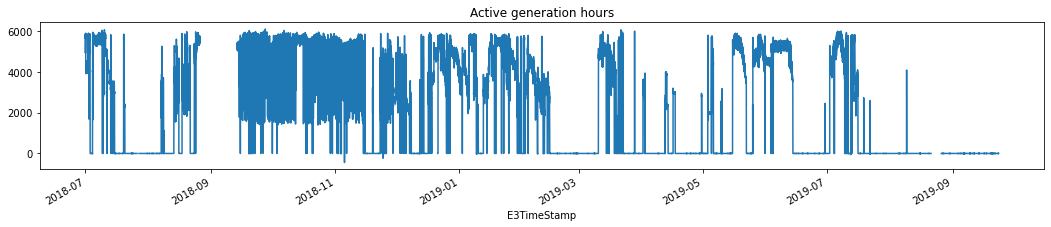

In [197]:
ax = df_telemetry.set_index('E3TimeStamp')['Gerador - Potência Ativa Média'].plot(figsize=(18,3))
ax.set_title('Active generation hours')

Percentage of NaN:
0.0641


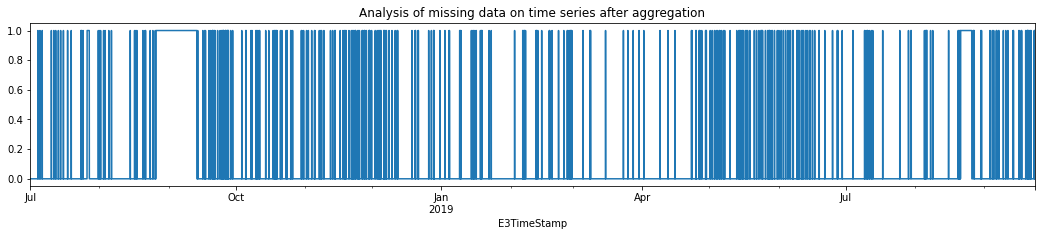

In [198]:
df = df_telemetry.set_index('E3TimeStamp').resample(FREQUENCY).agg('max').dropna(thresh=10)

df = df.drop(columns='Nível Barramento')

df['EVI'] = np.sqrt( np.power(df['Vibração Mancal Combinado Radial Vertical'], 2) + \
    np.power(df['Vibração Mancal Combinado Radial Horizontal'],2) + np.power(df['Vibração Mancal Combinado Axial'],2))


df['isMissing'] = 0
df = df.resample(FREQUENCY).max()
df['isMissing'] = df['isMissing'].fillna(1)

print("Percentage of NaN:")
print((df.isna().sum(axis=1) > 10).mean().round(4))
ax = df['isMissing'].plot(figsize=(18,3))
ax.set_title('Analysis of missing data on time series after aggregation' )
plt.show()

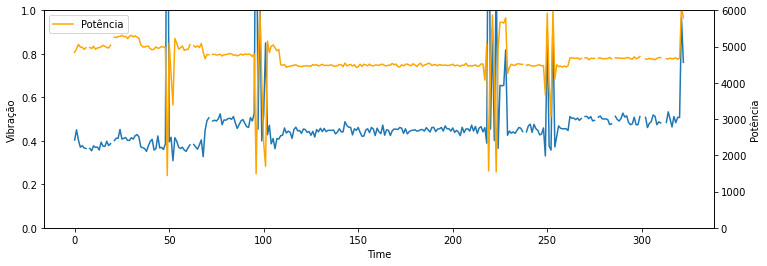

In [199]:
df_plot = df.loc['2018-9-26 11:44':'2018-9-27 14:39']


f, ax = plt.subplots(figsize=(12,4))
ax.plot(df_plot['EVI'].values, label='Vibração')
ax2 = ax.twinx()
ax2.plot(df_plot['Gerador - Potência Aparente Média'].values, color='orange', label='Potência')
ax2.set_ylim([0,6000])
ax.set_ylim([0,1])
ax.set_ylabel('Vibração')
ax2.set_ylabel('Potência')
ax.set_xlabel('Time')
plt.legend()

### Estados operacionais

In [200]:
df_event = pd.read_excel('../data/raw/EstadosOperativos.xlsx', sheet_name='BANCO', parse_dates=['Inicio', 'Fim'], usecols=[0,1,4,7,8,10,11,12,13,14,15,16,17,18])
df_event = df_event[df_event['Cód.UG'] == f'SC-ADOP-0UG{GENERATOR}']

df_event = df_event[(df_event.Inicio >= df.index.min()) & (df_event.Fim < df.index.max())]

df_event['Breakdown'] = df_event['EstadoOperativo'].shift(-1).apply(lambda x: True if x == 'HDF' else False)

df_event = df_event.reset_index()

df_event.head()

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


index        Cód.UG EstadoOperativo              Inicio  \
0  54489  SC-ADOP-0UG1             LIG 2018-07-01 00:00:00   
1  54490  SC-ADOP-0UG1             HRD 2018-07-03 07:47:15   
2  54491  SC-ADOP-0UG1             LIG 2018-07-04 12:22:00   
3  54492  SC-ADOP-0UG1             HDP 2018-07-09 09:52:53   
4  54493  SC-ADOP-0UG1             LIG 2018-07-09 10:25:59   

                  Fim                Tempo Origem da Falha Classificação  \
0 2018-07-03 07:47:15  1900-01-02 07:47:15          Ligada           NaN   
1 2018-07-04 12:22:00  1900-01-01 04:34:45           Usina  Conveniência   
2 2018-07-09 09:52:53  1900-01-04 21:30:53          Ligada           NaN   
3 2018-07-09 10:25:59             00:33:06           Usina    Manutenção   
4 2018-07-09 12:45:00             02:19:01          Ligada           NaN   

                Falha                         Descrição / Causa da Falha  \
0              LIGADA                                                NaN   
1  Reposição de nível      Unidade parada por indisponibilidade hídrica.   
2              LIGADA                                                NaN   
3    Limpeza de Grade  Unidades paradas para a rejeição de carga devi...   
4              LIGADA                                                NaN   

   Responsável Tratativa               Ação realizada para solução da falha  \
0                    NaN                                                NaN   
1                    COG  Aguardando a normalização do nível montante pa...   
2                    NaN                                                NaN   
3  Mantenedor/Oper local  Aguardando a liberação da unidade para retorna...   
4                    NaN                                                NaN   

  Justificativa religamento após 30min Correção                 Just.  \
0                                  NaN        0      Preenchimento ok   
1                                  NaN        0      Preenchimento ok   
2                                  NaN        0      Preenchimento ok   
3                                  NaN        3  Classificação Errada   
4                                  NaN        0      Preenchimento ok   

   Breakdown  
0      False  
1      False  
2      False  
3      False  
4      False

In [201]:
# Check subsequent LIG states
print(df_event[(df_event['EstadoOperativo'] == 'LIG') & (df_event['EstadoOperativo'] == df_event['EstadoOperativo'].shift(-1))])

subseq_lig = df_event.loc[(df_event['EstadoOperativo'] == 'LIG') & (df_event['EstadoOperativo'] == df_event['EstadoOperativo'].shift(1)), 'Fim']

# Assign end to next subsequent LIG
df_event.loc[(df_event['EstadoOperativo'] == 'LIG') & (df_event['EstadoOperativo'] == df_event['EstadoOperativo'].shift(-1)), 'Fim'] = subseq_lig.values

# Drop last lig State
df_event = df_event.drop(subseq_lig.index)

    index        Cód.UG EstadoOperativo              Inicio        Fim  \
59  54548  SC-ADOP-0UG1             LIG 2018-09-27 14:55:00 2018-10-01   

                  Tempo Origem da Falha Classificação   Falha  \
59  1900-01-03 09:05:00          Ligada           NaN  LIGADA   

   Descrição / Causa da Falha Responsável Tratativa  \
59                        NaN                   NaN   

   Ação realizada para solução da falha Justificativa religamento após 30min  \
59                                  NaN                                  NaN   

   Correção             Just.  Breakdown  
59        0  Preenchimento ok      False  


In [202]:
df_plot[df_plot['Gerador - Potência Aparente Média'] > 100][:12]

Gerador - Corrente Média  Gerador - Corrente R  \
E3TimeStamp                                                           
2018-09-26 11:45:00                     198.0                 197.0   
2018-09-26 11:50:00                     200.0                 199.0   
2018-09-26 11:55:00                     203.0                 202.0   
2018-09-26 12:00:00                     200.0                 199.0   
2018-09-26 12:05:00                     200.0                 199.0   
2018-09-26 12:10:00                     197.0                 196.0   
2018-09-26 12:15:00                     199.0                 198.0   
2018-09-26 12:25:00                     200.0                 199.0   
2018-09-26 12:30:00                     198.0                 197.0   
2018-09-26 12:35:00                     200.0                 200.0   
2018-09-26 12:40:00                     198.0                 197.0   
2018-09-26 12:45:00                     199.0                 198.0   

                     Gerador - Corrente S  Gerador - Corrente T  \
E3TimeStamp                                                       
2018-09-26 11:45:00                 200.0                 198.0   
2018-09-26 11:50:00                 202.0                 200.0   
2018-09-26 11:55:00                 204.0                 203.0   
2018-09-26 12:00:00                 202.0                 200.0   
2018-09-26 12:05:00                 202.0                 200.0   
2018-09-26 12:10:00                 199.0                 197.0   
2018-09-26 12:15:00                 201.0                 199.0   
2018-09-26 12:25:00                 202.0                 200.0   
2018-09-26 12:30:00                 199.0                 198.0   
2018-09-26 12:35:00                 202.0                 200.0   
2018-09-26 12:40:00                 200.0                 198.0   
2018-09-26 12:45:00                 201.0                 199.0   

                     Gerador - Energia Consumida  \
E3TimeStamp                                        
2018-09-26 11:45:00                     1001.382   
2018-09-26 11:50:00                     1001.395   
2018-09-26 11:55:00                     1001.408   
2018-09-26 12:00:00                     1001.421   
2018-09-26 12:05:00                     1001.434   
2018-09-26 12:10:00                     1001.447   
2018-09-26 12:15:00                     1001.460   
2018-09-26 12:25:00                     1001.486   
2018-09-26 12:30:00                     1001.499   
2018-09-26 12:35:00                     1001.512   
2018-09-26 12:40:00                     1001.525   
2018-09-26 12:45:00                     1001.538   

                     Gerador - Energia Ativa Fornecida  \
E3TimeStamp                                              
2018-09-26 11:45:00                          15783.296   
2018-09-26 11:50:00                          15783.717   
2018-09-26 11:55:00                          15784.129   
2018-09-26 12:00:00                          15784.545   
2018-09-26 12:05:00                          15784.959   
2018-09-26 12:10:00                          15785.374   
2018-09-26 12:15:00                          15785.789   
2018-09-26 12:25:00                          15786.618   
2018-09-26 12:30:00                          15787.033   
2018-09-26 12:35:00                          15787.448   
2018-09-26 12:40:00                          15787.864   
2018-09-26 12:45:00                          15788.277   

                     Gerador - Energia Reativa Fornecida  \
E3TimeStamp                                                
2018-09-26 11:45:00                               59.105   
2018-09-26 11:50:00                               59.105   
2018-09-26 11:55:00                               59.105   
2018-09-26 12:00:00                               59.105   
2018-09-26 12:05:00                               59.105   
2018-09-26 12:10:00                               59.105   
2018-09-26 12:15:00                               59.105   
2018-

In [203]:
snapshots = []

for index, row in df_event.iterrows():

    print(index)
    start = row['Inicio']
    end = row['Fim']
    state = row['EstadoOperativo'] 

    #if state == 'LIG':
        #start -= timedelta(hours=1)
        #end   += timedelta(hours=1)
        
    #start = start if row['EstadoOperativo'] != 'LIG' else start - timedelta(hours=1)
    
    df_plot = df.loc[start:end].copy()
    
    if df_plot.isna().all().sum() < 10:

        #df_plot = df_plot.interpolate()

        if state == 'LIG':

            cut_start = df_plot[:12][(df_plot['EVI'] > 0.5) &
                (df_plot['Gerador - Potência Aparente Média'] > 10)].head(1).index


            cut_end = df_plot[-12:][(df_plot['EVI'] > 0.5) &
                (df_plot['Gerador - Potência Aparente Média'] > 10)].tail(1).index
            
            if cut_start.size > 0:
                df_plot = df_plot.loc[cut_start[0]:].copy()

            #if cut_end.size > 0:
            #    df_plot = df_plot.loc[:cut_end[0]].copy()

            #df_plot = df_plot[(df_plot['Vibração Mancal Combinado Radial Horizontal'] > 0.1) |
            #    (df_plot['Gerador - Potência Aparente Média'] > 10)]

            df_plot['Breakdown'] = row['Breakdown']
            df_plot['Run'] = index
            snapshots.append(df_plot)

    
    

#    f, ax = plt.subplots(figsize=(12,2.5))
#    ax.plot(df_plot['Vibração Mancal Combinado Radial Horizontal'].values, label='Vibração')
#    ax2 = ax.twinx()
#    ax2.plot(df_plot['Gerador - Potência Aparente Média'].values, color='orange', label='Potência')
#    ax2.set_ylim([0,6000])
#    ax.set_ylim([0,1])
#    ax.set_ylabel('Vibração')
#    ax2.set_ylabel('Potência')
#    ax.set_xlabel('Time (5min)' )
#    plt.title(row['EstadoOperativo'])
#    plt.legend()
#    plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/var/folders/7w/rmdb2s696z7195b4qbsm0hk80000gn/T/ipykernel_1416/4031459437.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cut_start = df_plot[:12][(df_plot['EVI'] > 0.5) &
/var/folders/7w/rmdb2s696z7195b4qbsm0hk80000gn/T/ipykernel_1416/4031459437.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cut_end = df_plot[-12:][(df_plot['EVI'] > 0.5) &


50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
3

In [204]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

df_new = pd.concat(snapshots)

df_grouped = df_new.groupby('Run')['Breakdown'].count()
selected_runs = df_grouped[df_grouped > 1].index.tolist()

df_new = df_new[df_new.Run.isin(selected_runs)]

df_new['Run'] = enc.fit_transform(df_new['Run'].values.reshape(-1, 1)).astype(int)

df_new.head()

Gerador - Corrente Média  Gerador - Corrente R  \
E3TimeStamp                                                           
2018-07-01 00:00:00                     228.0                 227.0   
2018-07-01 00:05:00                     233.0                 233.0   
2018-07-01 00:10:00                     235.0                 234.0   
2018-07-01 00:15:00                     232.0                 227.0   
2018-07-01 00:20:00                     235.0                 233.0   

                     Gerador - Corrente S  Gerador - Corrente T  \
E3TimeStamp                                                       
2018-07-01 00:00:00                 230.0                 227.0   
2018-07-01 00:05:00                 235.0                 232.0   
2018-07-01 00:10:00                 237.0                 234.0   
2018-07-01 00:15:00                 230.0                 231.0   
2018-07-01 00:20:00                 237.0                 234.0   

                     Gerador - Energia Consumida  \
E3TimeStamp                                        
2018-07-01 00:00:00                      838.596   
2018-07-01 00:05:00                      838.596   
2018-07-01 00:10:00                      838.596   
2018-07-01 00:15:00                      838.596   
2018-07-01 00:20:00                      838.596   

                     Gerador - Energia Ativa Fornecida  \
E3TimeStamp                                              
2018-07-01 00:00:00                           9777.840   
2018-07-01 00:05:00                           9778.316   
2018-07-01 00:10:00                           9778.791   
2018-07-01 00:15:00                           9779.268   
2018-07-01 00:20:00                           9779.743   

                     Gerador - Energia Reativa Fornecida  \
E3TimeStamp                                                
2018-07-01 00:00:00                                4.697   
2018-07-01 00:05:00                                4.706   
2018-07-01 00:10:00                                4.716   
2018-07-01 00:15:00                                4.726   
2018-07-01 00:20:00                                4.735   

                     Gerador - Frequência  Gerador - Potência Ativa Média  \
E3TimeStamp                                                                 
2018-07-01 00:00:00             60.000000                          5660.0   
2018-07-01 00:05:00             59.990002                          5708.0   
2018-07-01 00:10:00             60.000000                          5838.0   
2018-07-01 00:15:00             60.000000                          5636.0   
2018-07-01 00:20:00             60.009998                          5794.0   

                     Gerador - Potência Reativa Média  ...  UHCT Pressão Óleo  \
E3TimeStamp                                            ...                      
2018-07-01 00:00:00                             126.0  ...              138.0   
2018-07-01 00:05:00                             123.0  ...              133.0   
2018-07-01 00:10:00                             112.0  ...              154.0   
2018-07-01 00:15:00                             132.0  ...              145.0   
2018-07-01 00:20:00                             130.0  ...              139.0   

                     UHLM Fluxostato 02  Posição da Comporta  Vazão Turbinada  \
E3TimeStamp                                                                     
2018-07-01 00:00:00               23.51                100.0              0.0   
2018-07-01 00:05:00               22.67                100.0              0.0   
2018-07-01 00:10:00               22.99                100.0              0.0   
2018-07-01 00:15:00               23.18                100.0              0.0   
2018-07-01 00:20:00               23.02                100.0              0.0   

                     RegV - Rotor  Gerador - Potência Aparente Média  \
E3TimeStamp                                                            
2018-07-01 00:00:00     90.300003       

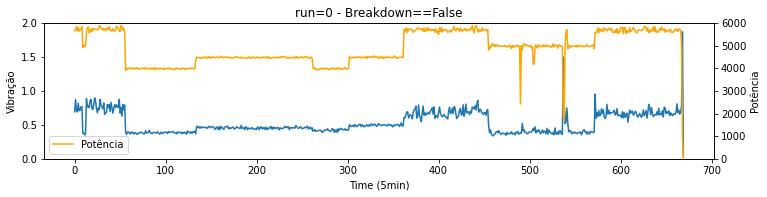

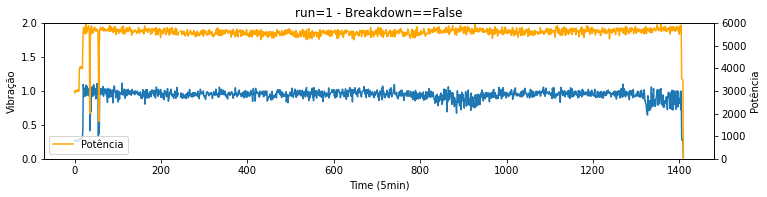

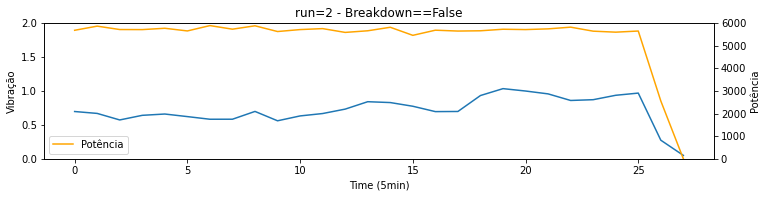

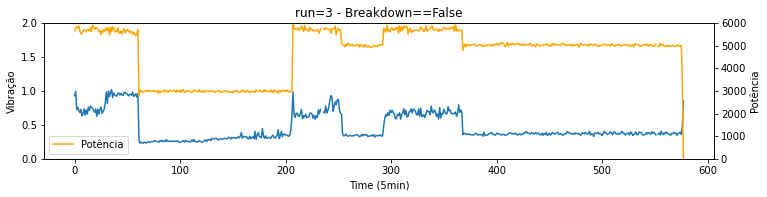

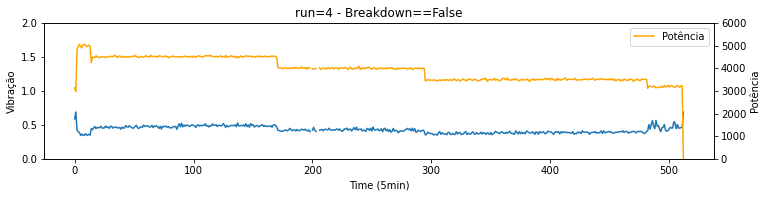

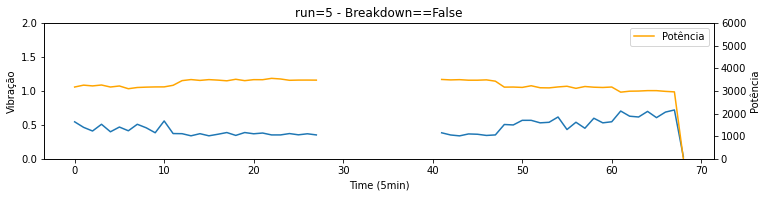

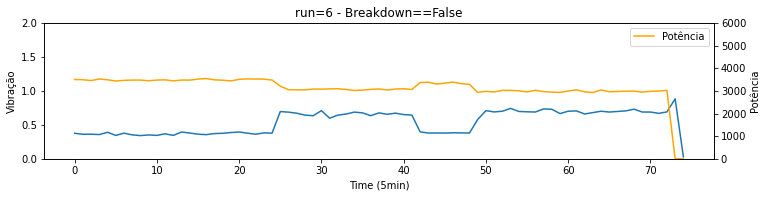

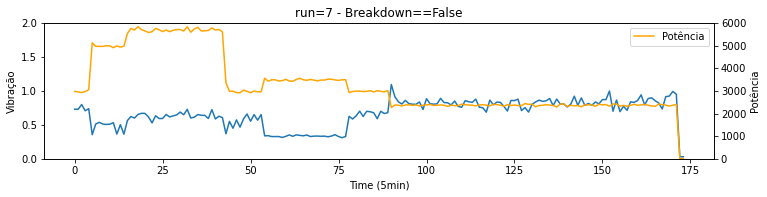

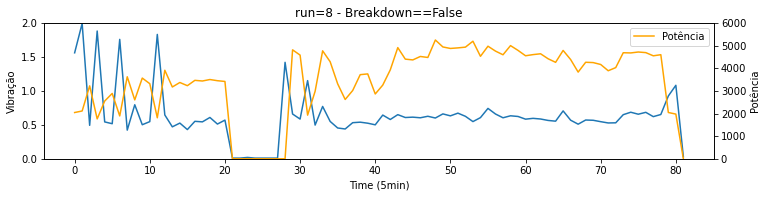

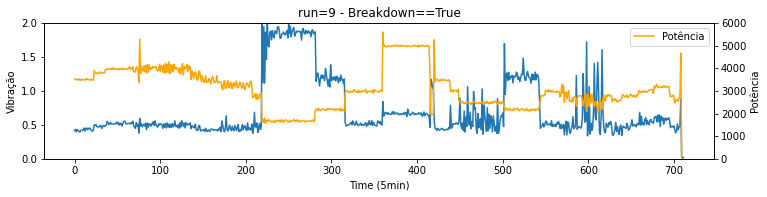

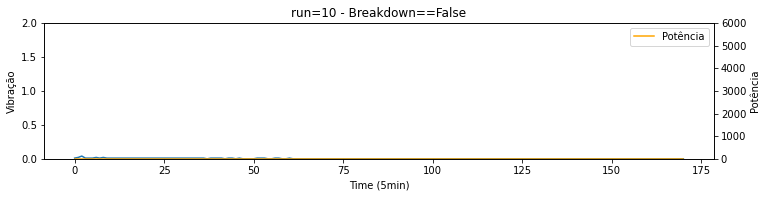

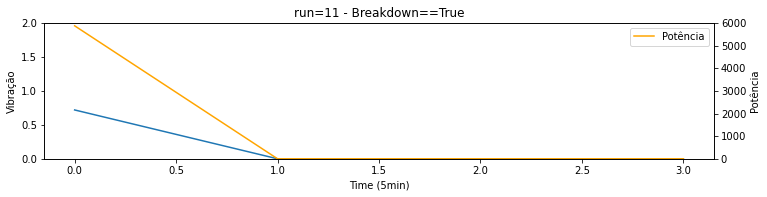

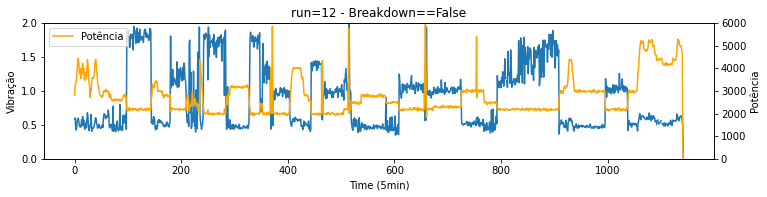

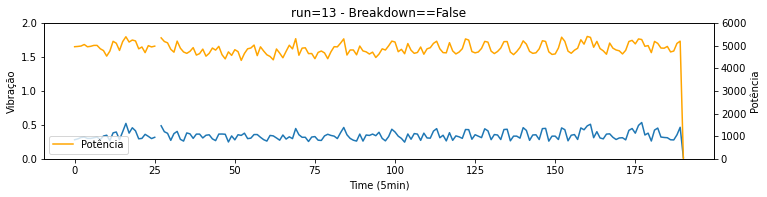

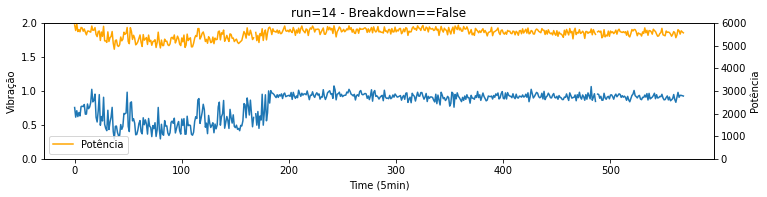

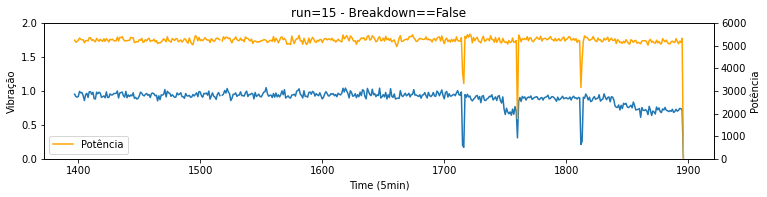

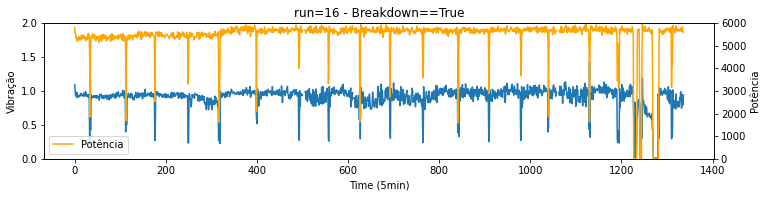

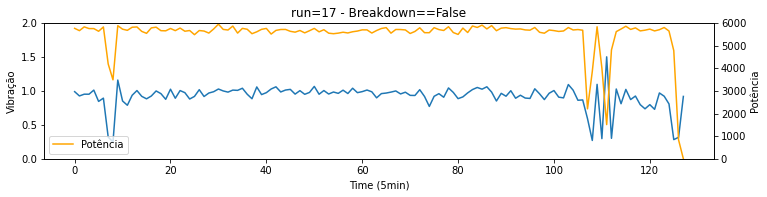

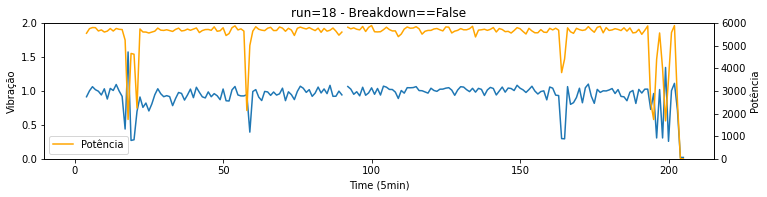

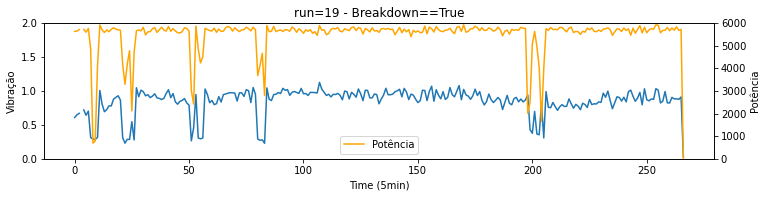

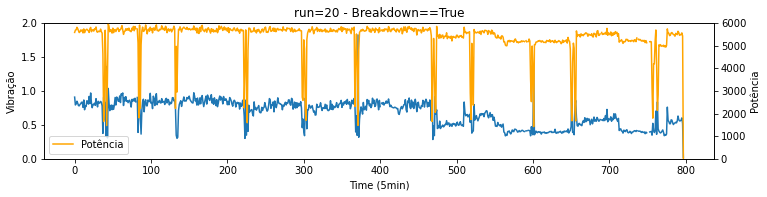

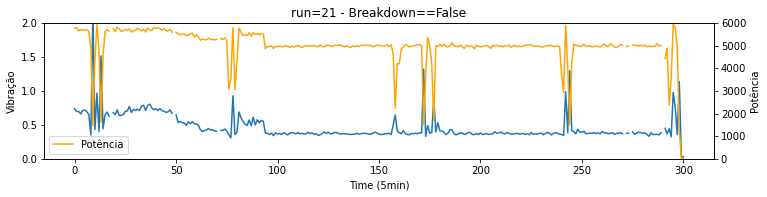

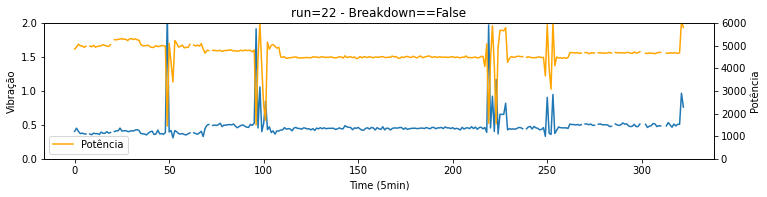

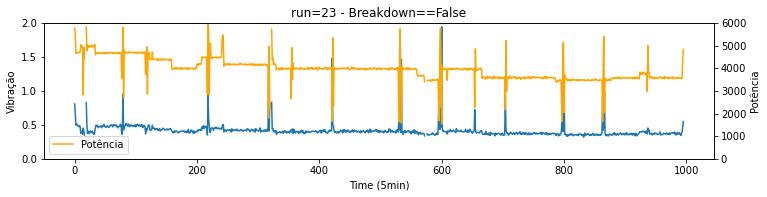

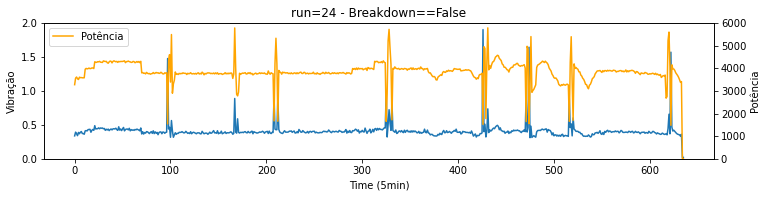

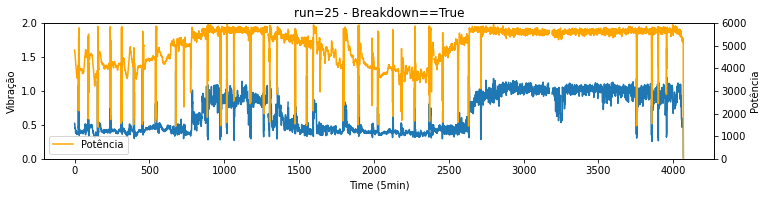

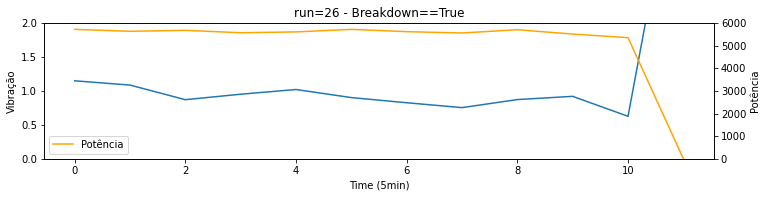

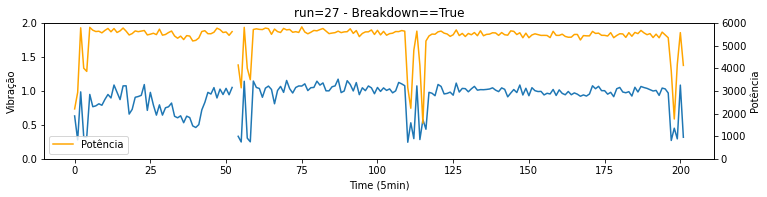

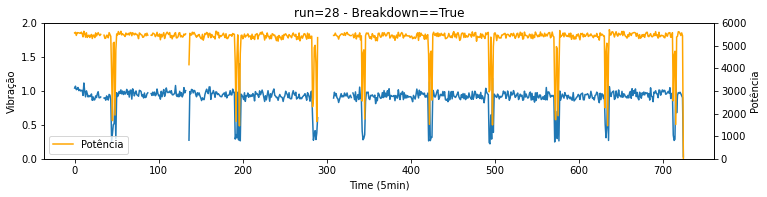

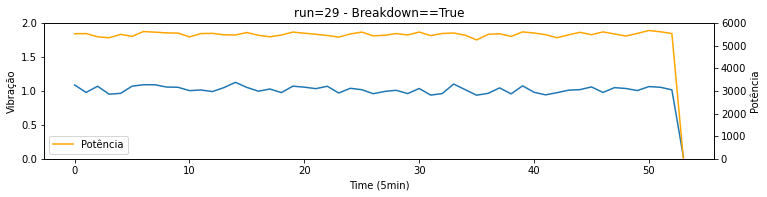

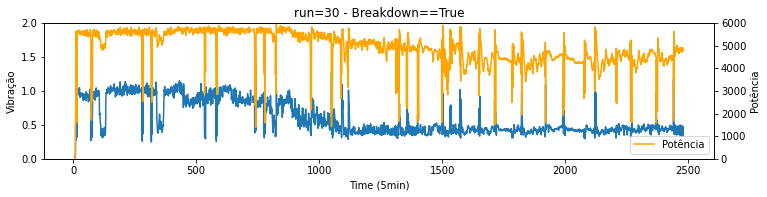

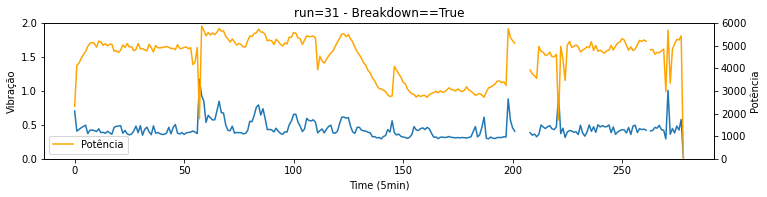

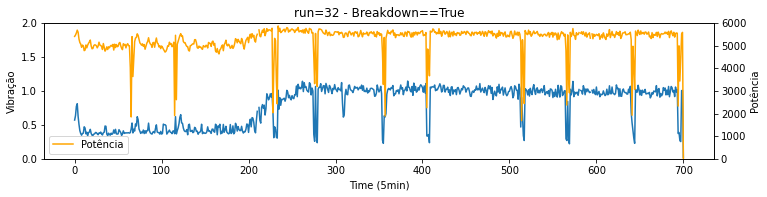

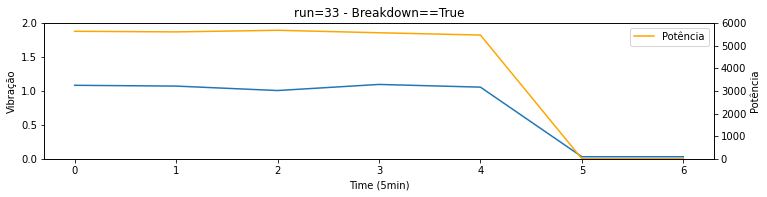

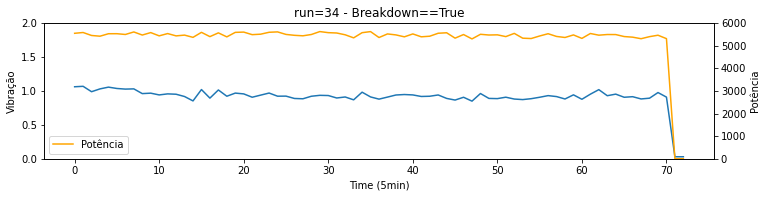

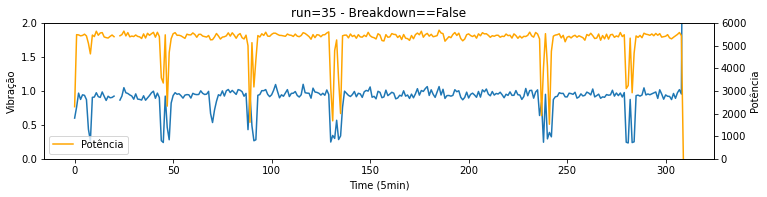

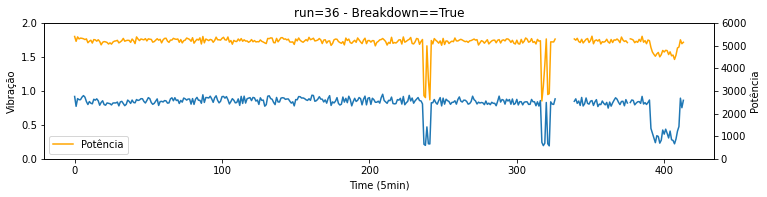

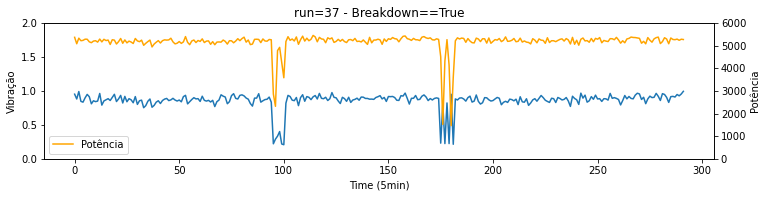

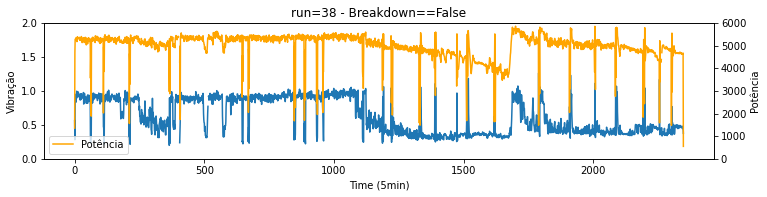

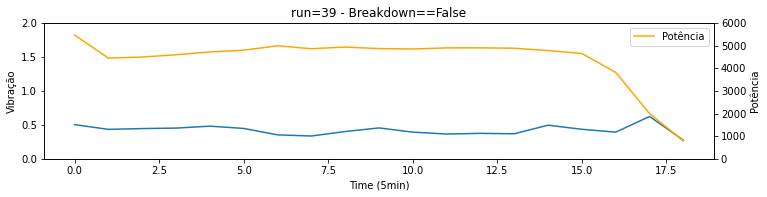

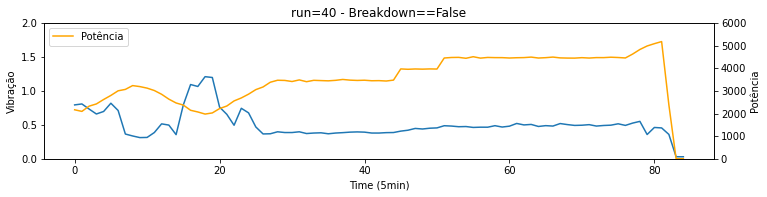

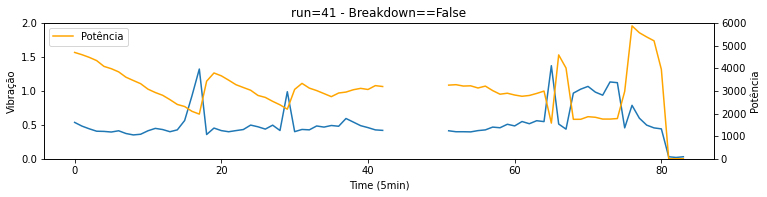

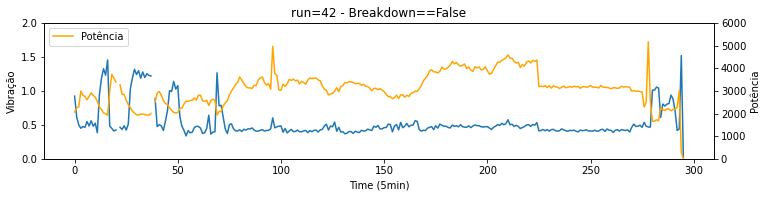

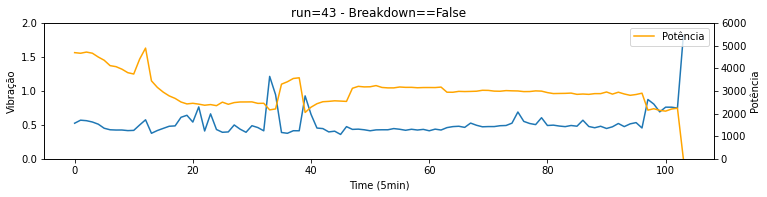

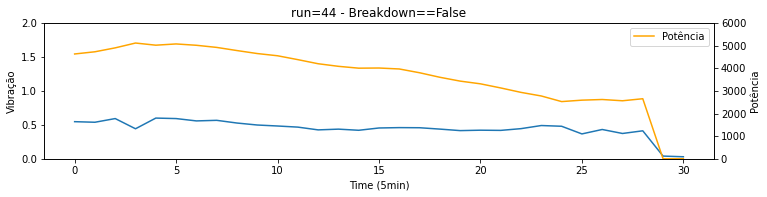

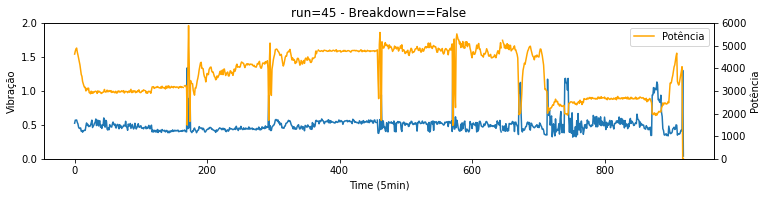

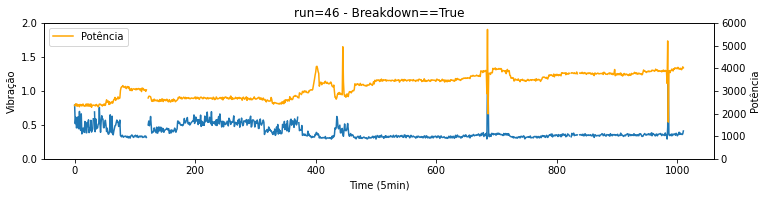

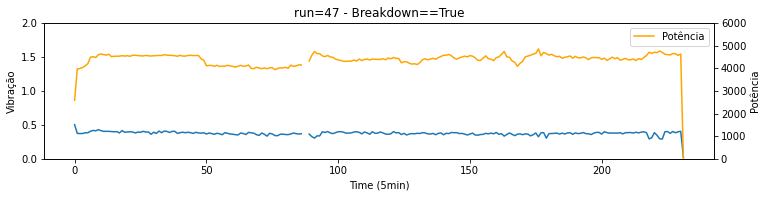

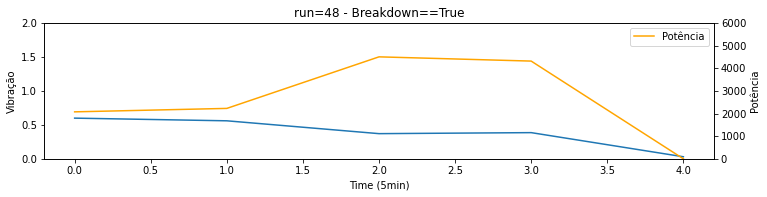

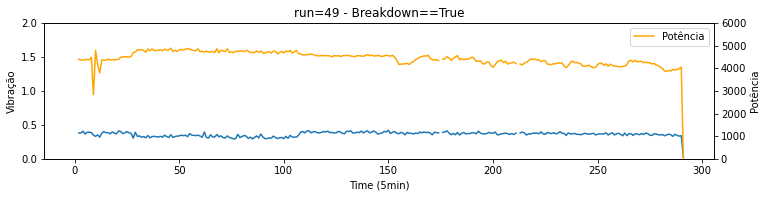

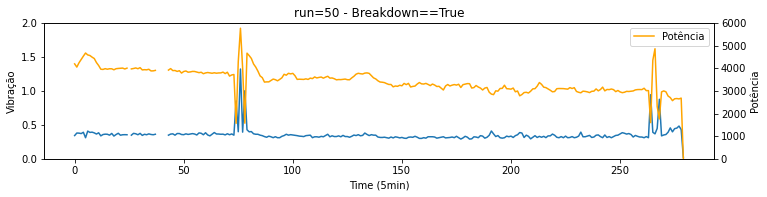

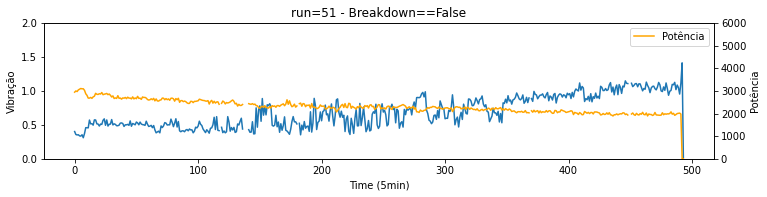

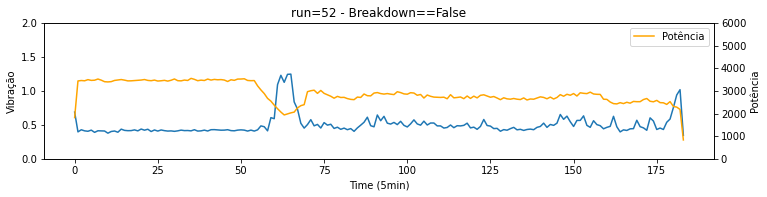

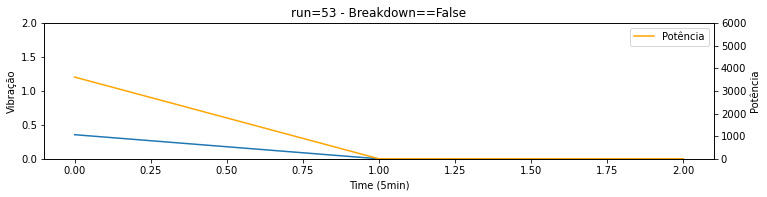

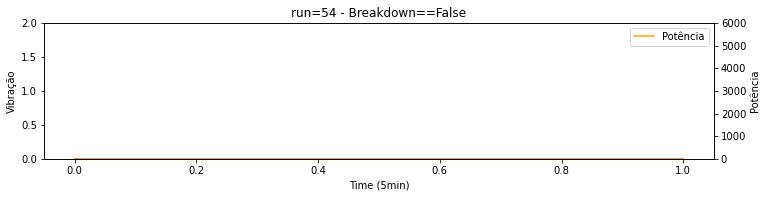

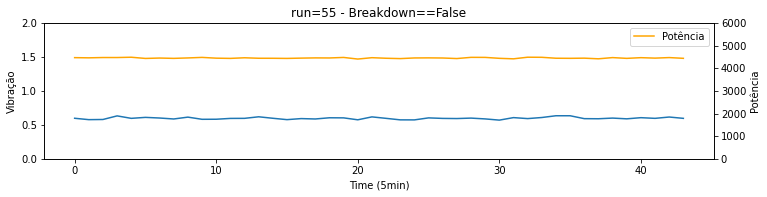

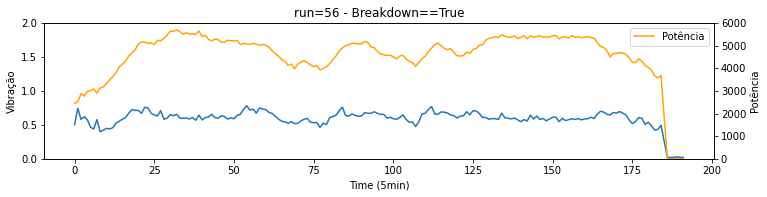

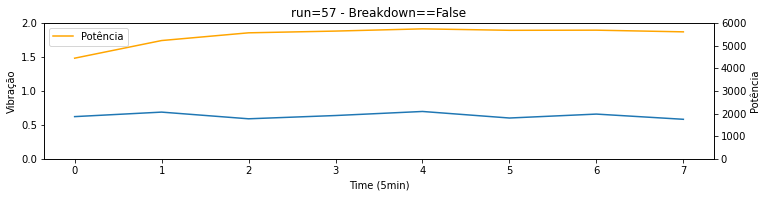

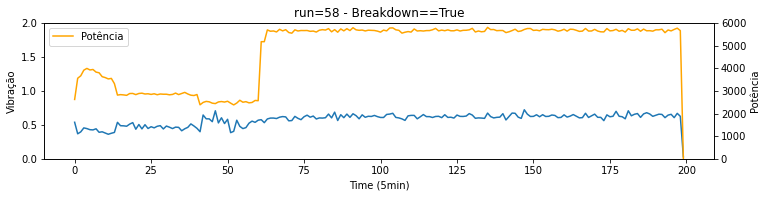

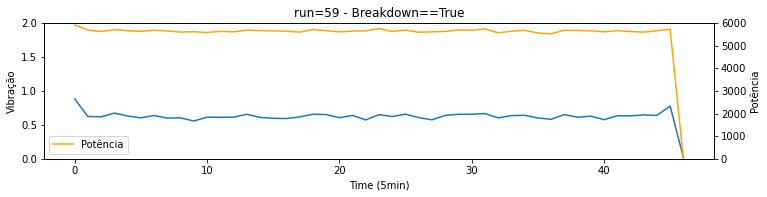

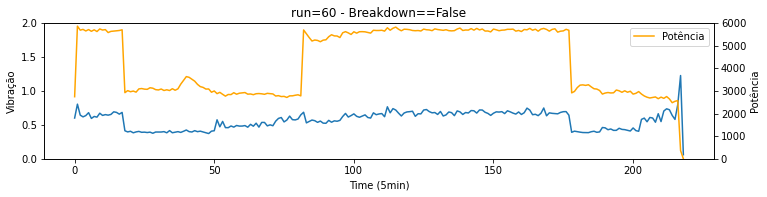

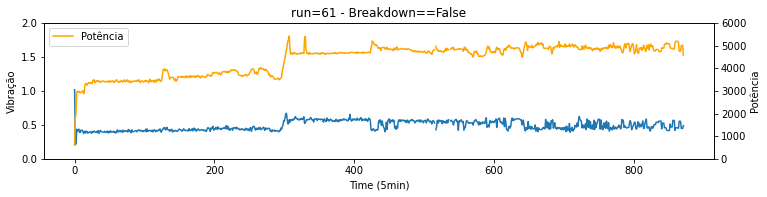

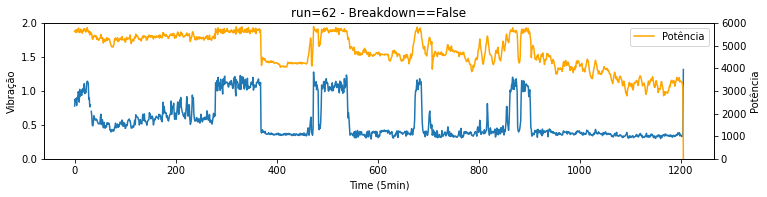

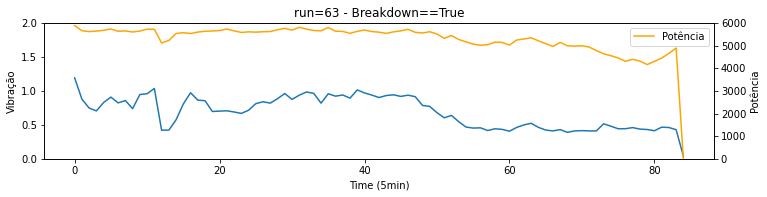

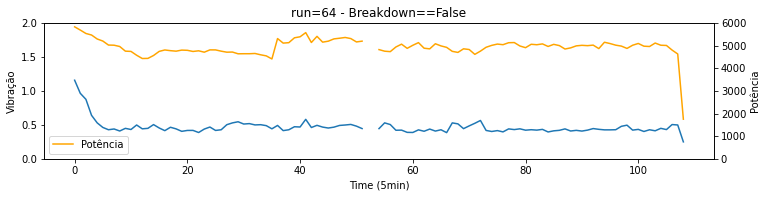

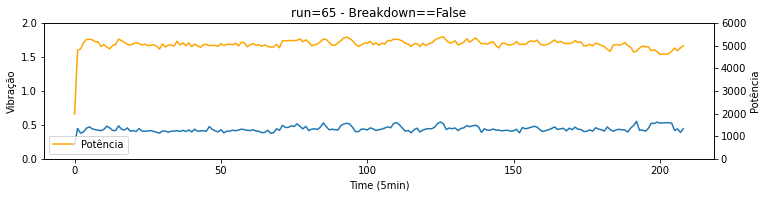

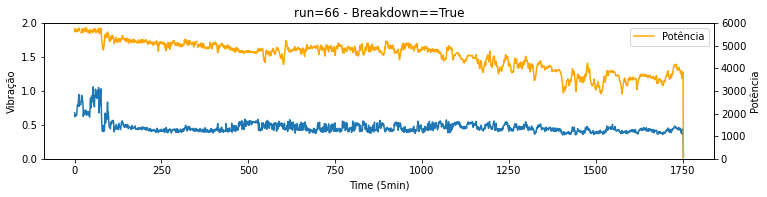

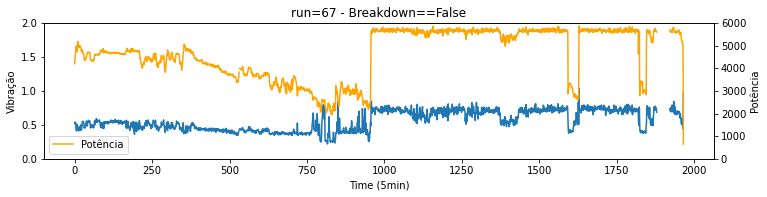

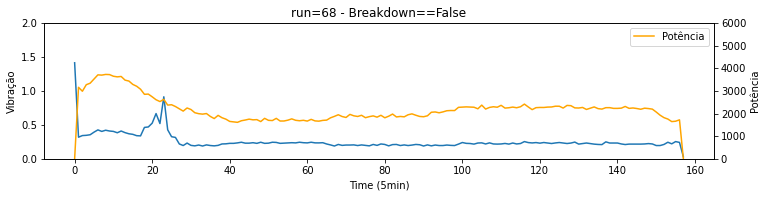

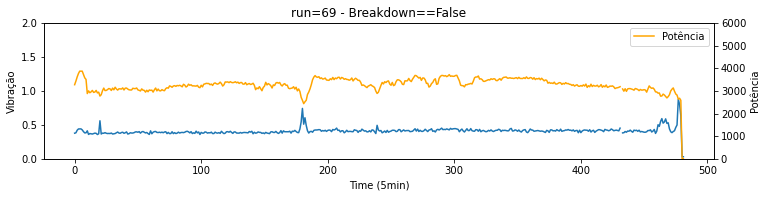

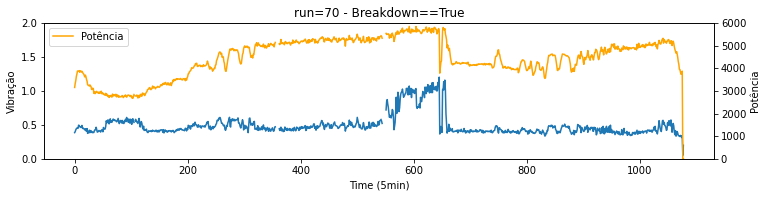

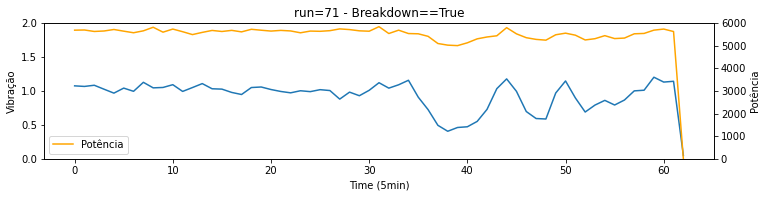

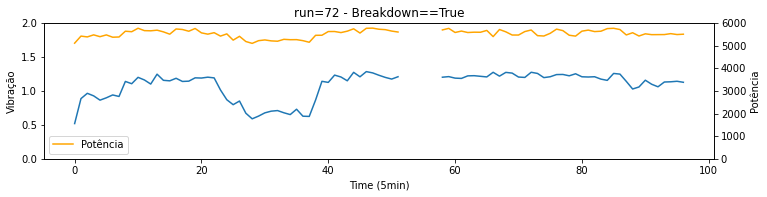

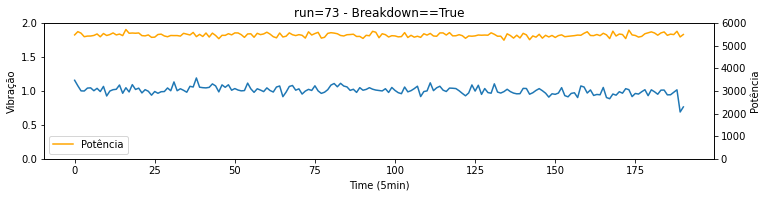

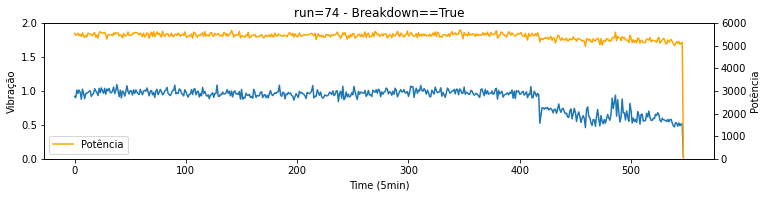

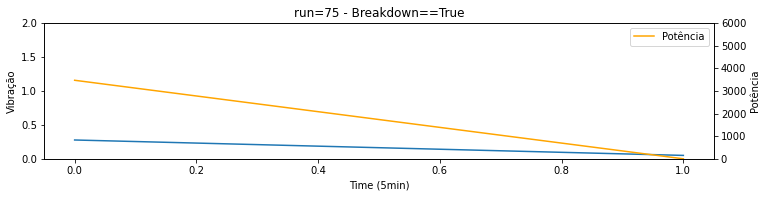

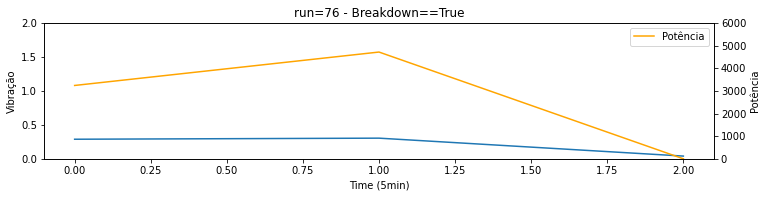

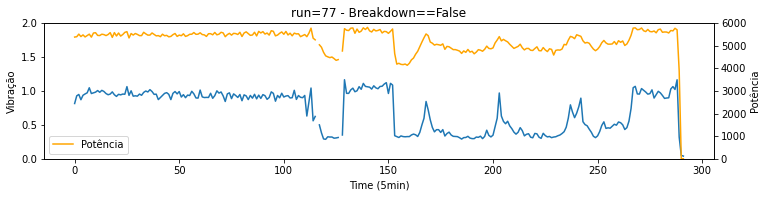

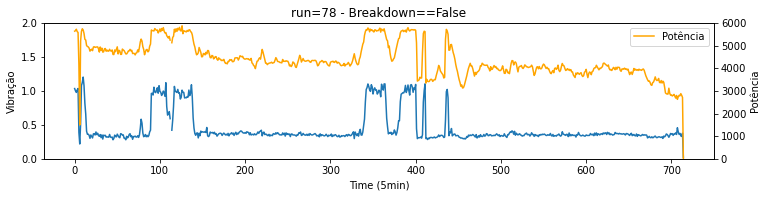

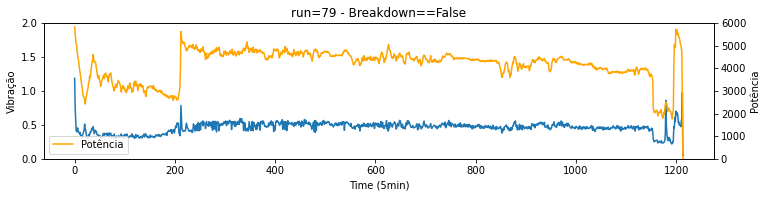

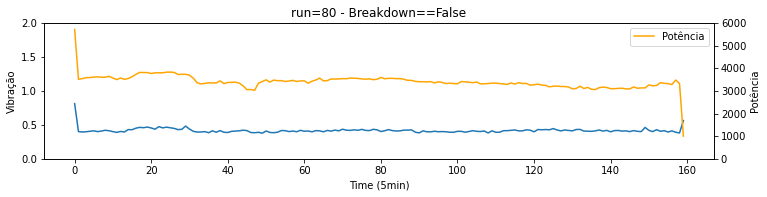

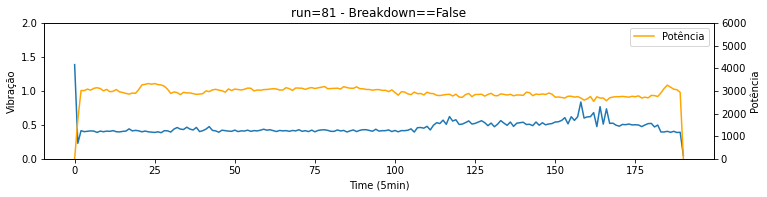

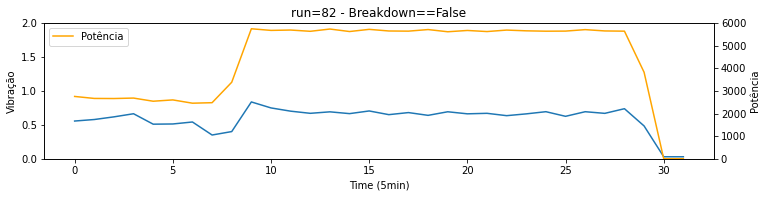

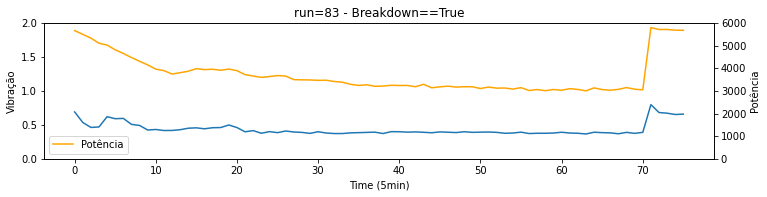

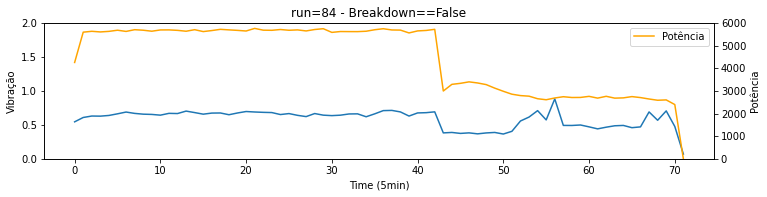

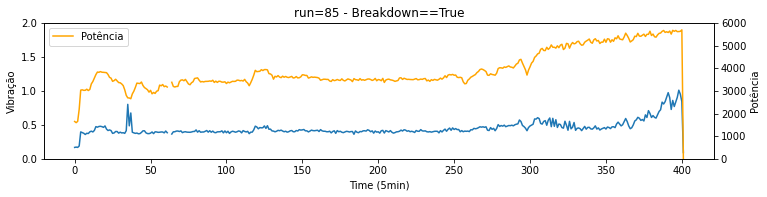

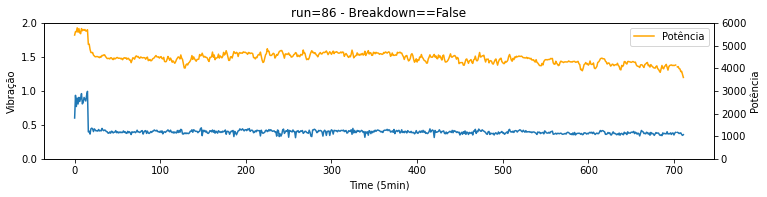

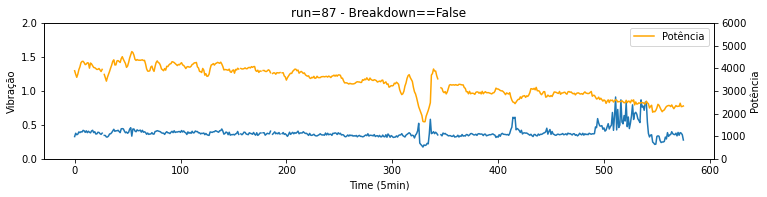

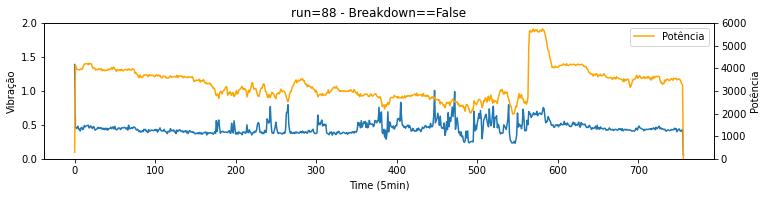

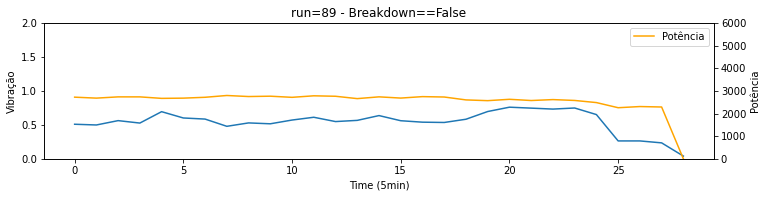

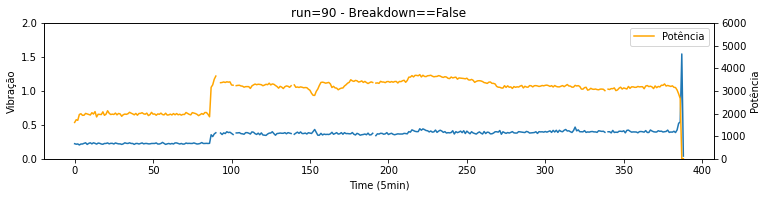

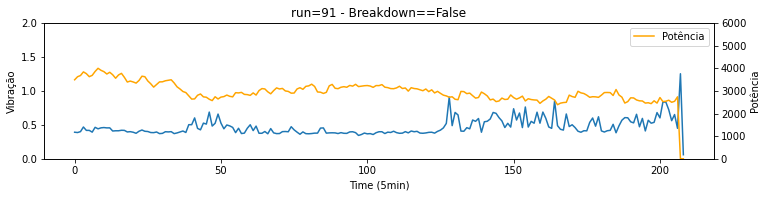

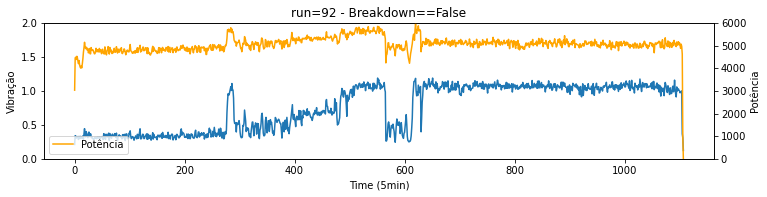

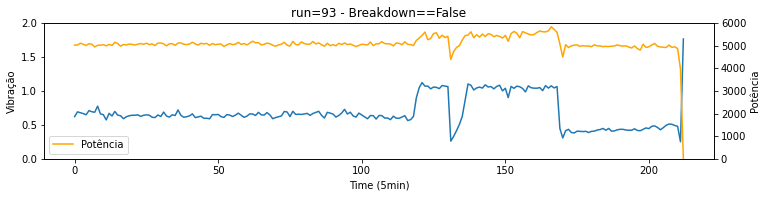

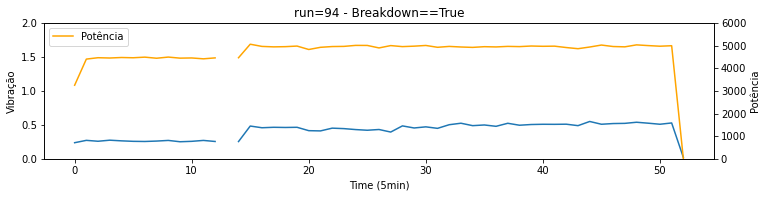

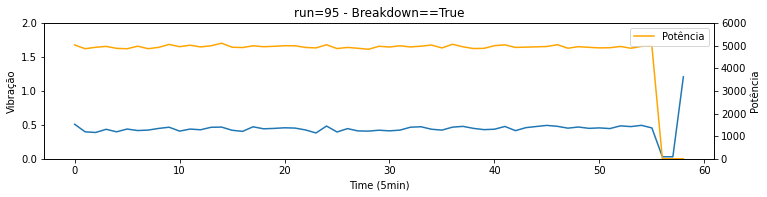

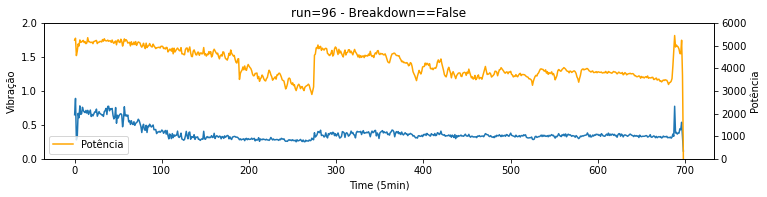

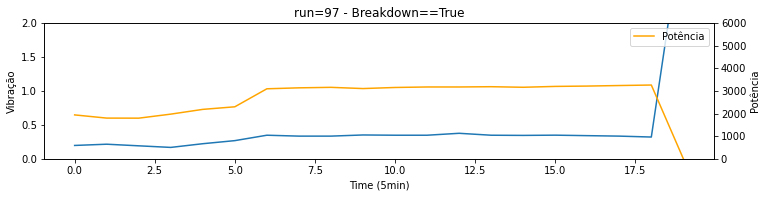

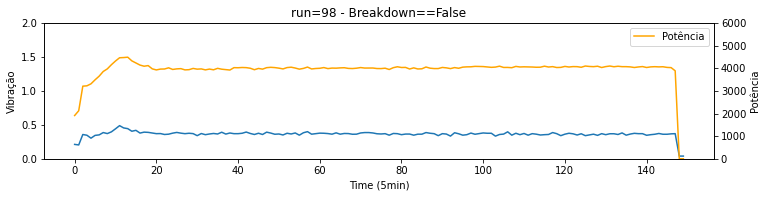

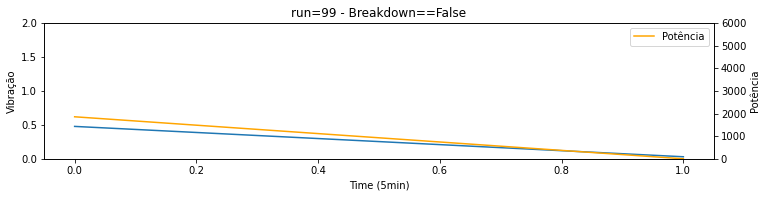

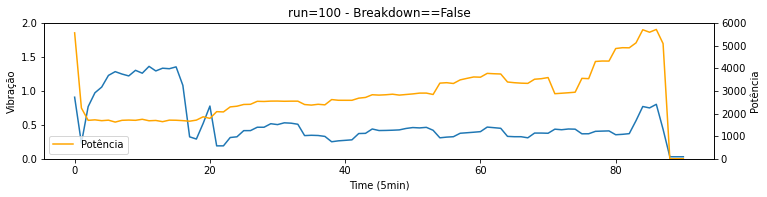

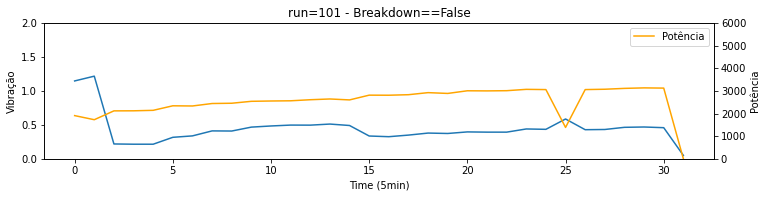

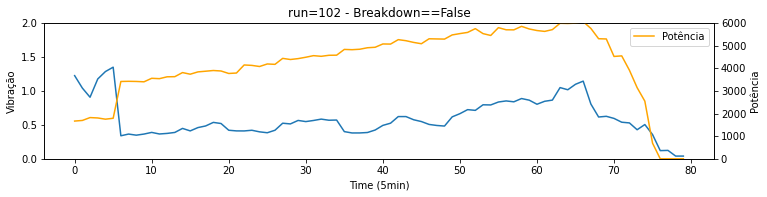

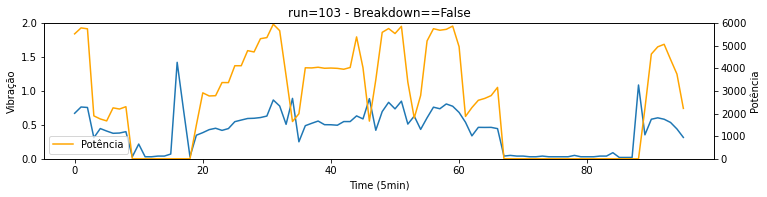

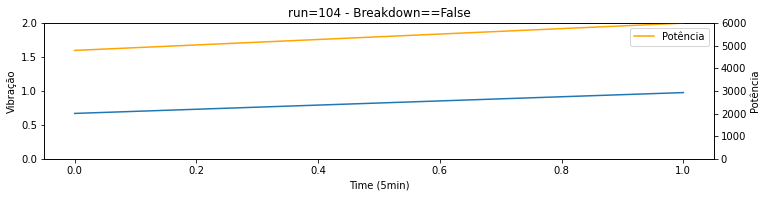

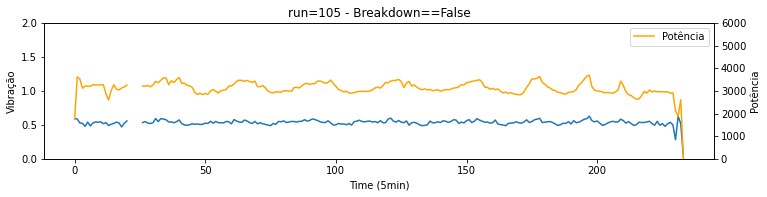

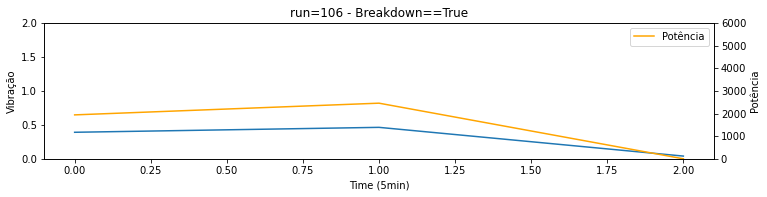

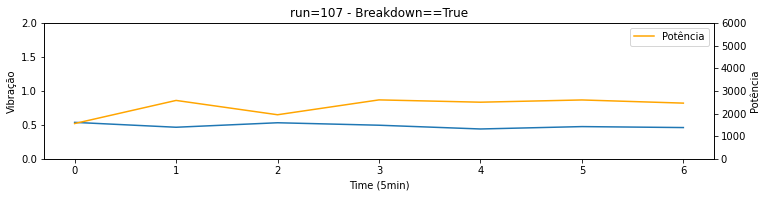

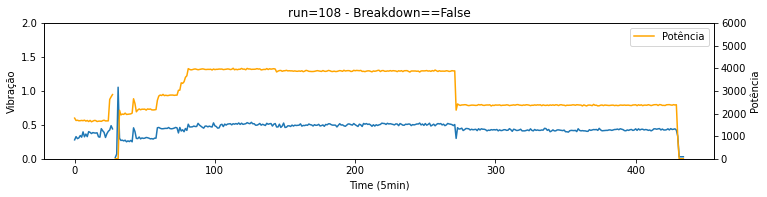

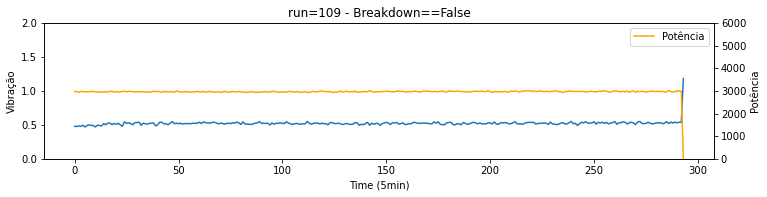

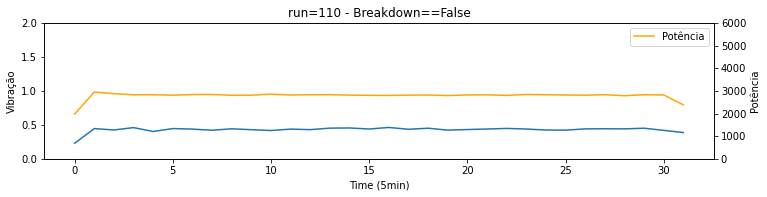

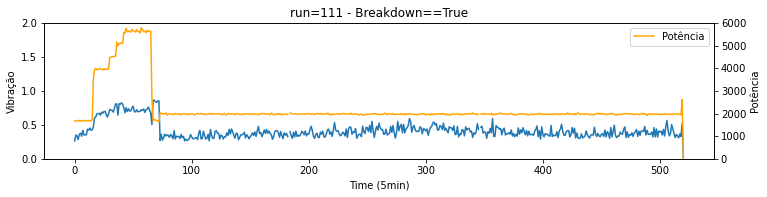

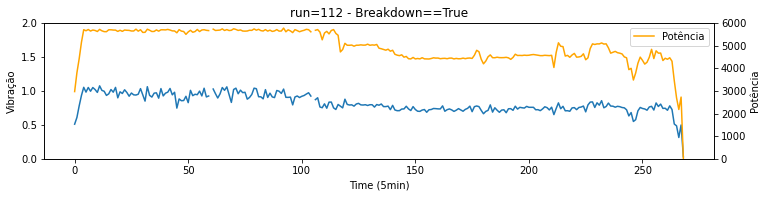

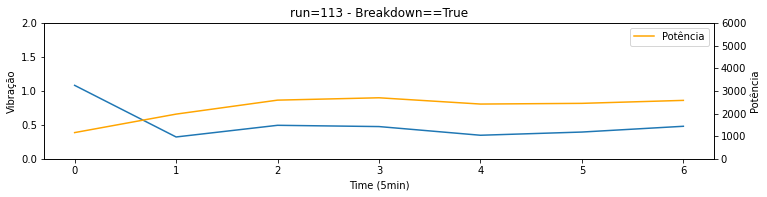

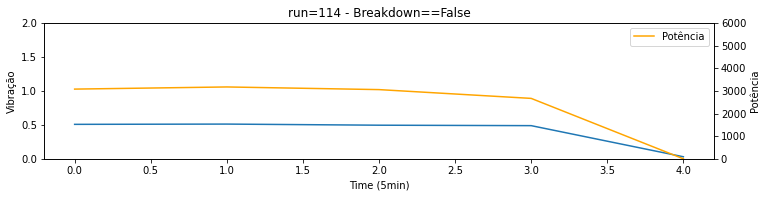

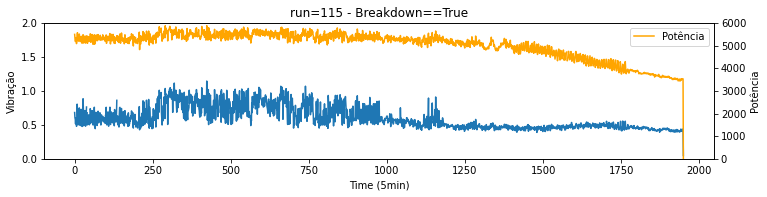

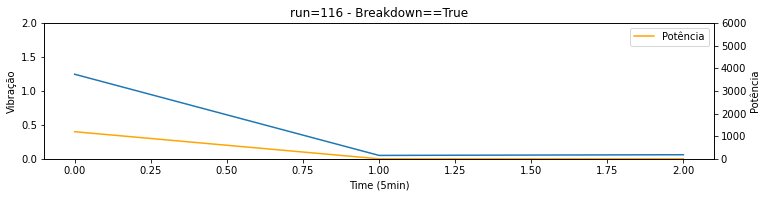

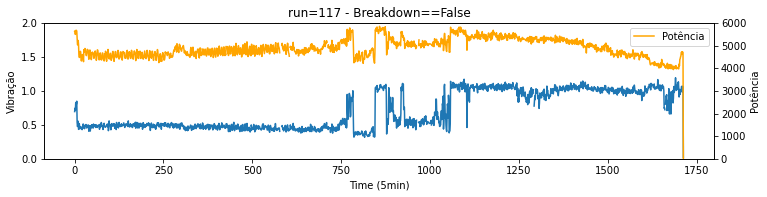

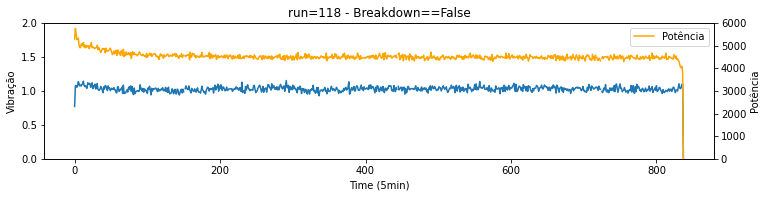

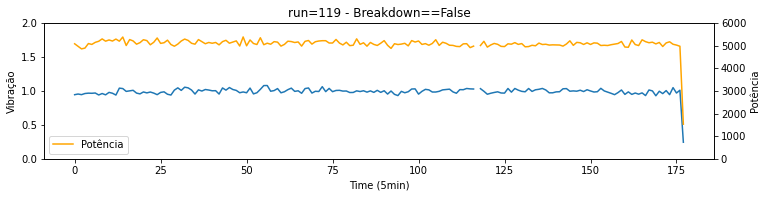

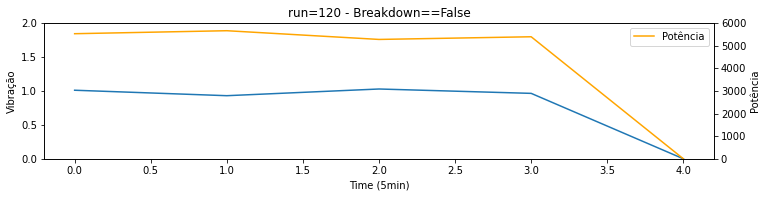

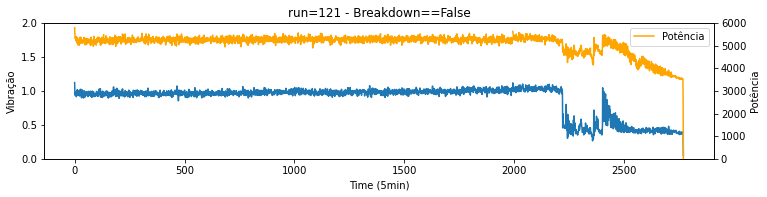

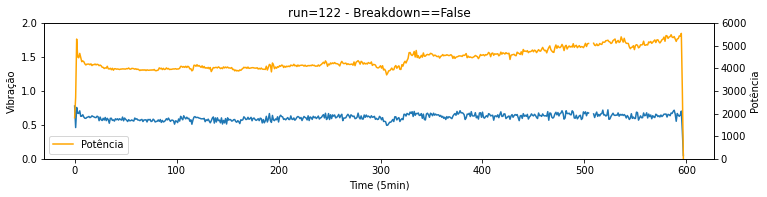

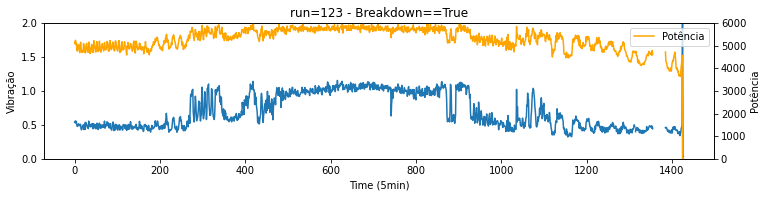

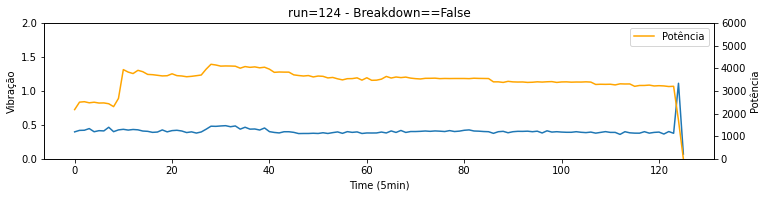

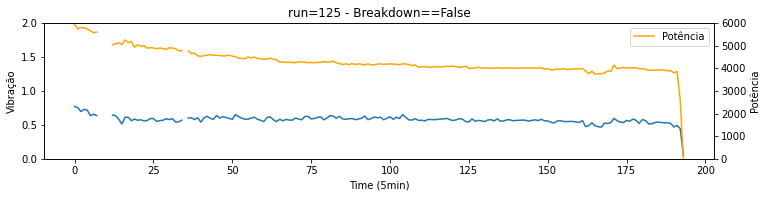

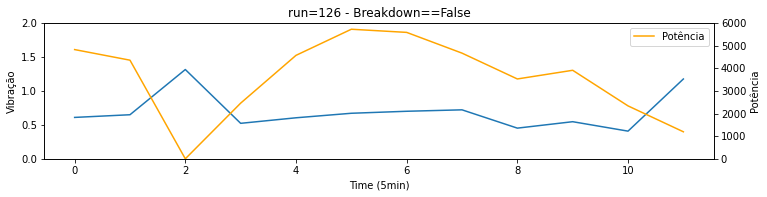

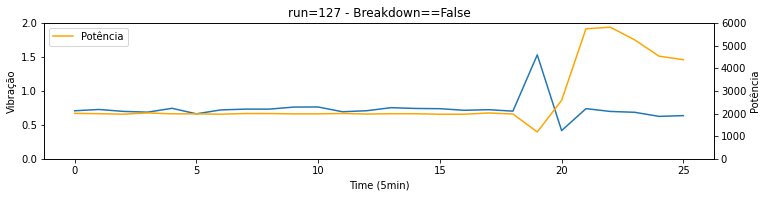

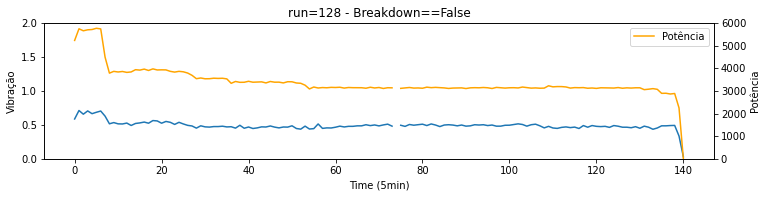

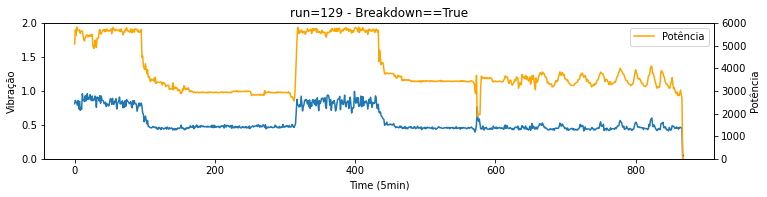

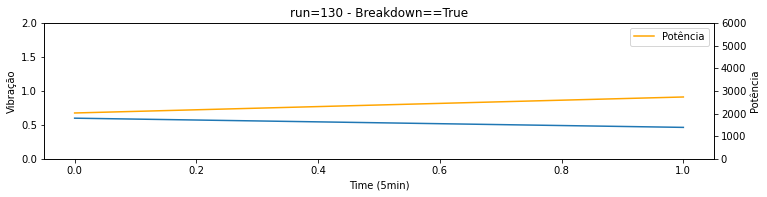

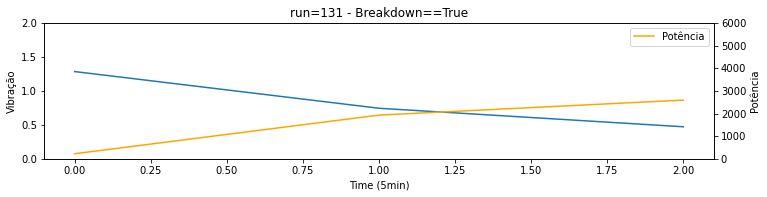

In [205]:
for run in range(df_new.Run.max()):

    df_plot = df_new[df_new.Run == run]
    breakdown = df_plot['Breakdown'][0]
    
    f, ax = plt.subplots(figsize=(12,2.5))
    ax.plot(df_plot['EVI'].values, label='Vibração')
    ax2 = ax.twinx()
    ax2.plot(df_plot['Gerador - Potência Aparente Média'].values, color='orange', label='Potência')
    ax2.set_ylim([0,6000])
    ax.set_ylim([0,2])
    ax.set_ylabel('Vibração')
    ax2.set_ylabel('Potência')
    ax.set_xlabel('Time (5min)' )
    plt.title(f"run={run} - Breakdown=={breakdown}")
    plt.legend()
    plt.show()

In [206]:
df_new.groupby('Run')['Breakdown'].max().value_counts()

False    83
True     50
Name: Breakdown, dtype: int64

### Save output

In [207]:
df_new.to_csv(f'../data/prepared/ap{GENERATOR}_data.csv')